In [1]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width=8, repr.plot.height=5)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.3
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [16]:
rr <- readxl::read_excel('Reinhart and Rogoff.xlsx') %>% rename_all(tolower) 

In [21]:
rr <- mutate(rr, dg = cut(`debt-to-gdp`, breaks=c(0, 30, 60, 90, Inf)))

In [23]:
rr %>% 
    filter(! (country == "New Zealand" & year < 1950)) %>% 
    filter(! (country == "Canada" & year < 1950)) %>% 
    filter(! (country == "Australia" & year < 1950)) %>% 
    group_by(dg) %>% summarize(mean(`growth rate`), median(`growth rate`))

dg,mean(`growth rate`),median(`growth rate`)
<fct>,<dbl>,<dbl>
"(0,30]",4.173523,4.145376
"(30,60]",3.092145,3.104629
"(60,90]",3.186575,2.897829
"(90,Inf]",2.026631,2.251850


## Steps needed to replicate R&R's numbers

See Herndon et al. (2013)

#### 1. Exclude Australia (1946-1950), NZ (1946-1949), and Canada (1946-1950).

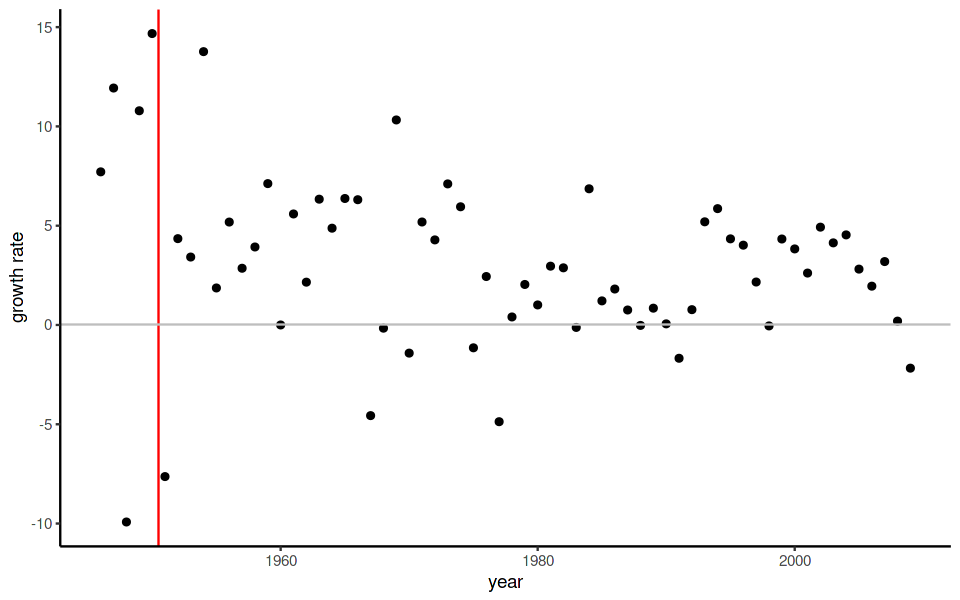

In [19]:
rr %>% filter(country == "New Zealand") %>% ggplot + 
    geom_point(aes(x=year, y=`growth rate`)) +
geom_vline(xintercept = 1950.5, color="red") +
    geom_hline(yintercept = 0, color = "grey")

#### 2. Exclude first five countries (by alphabetic order)

In [32]:
first_5 <- rr$country %>% unique %>% sort %>% head(5) %>% print
rr %>% group_by(country, dg) %>% 
    summarize(mu = mean(`growth rate`), n=n()) %>% 
    pivot_wider(id_cols = country, names_from = dg, values_from = c(mu, n)) %>% 
    filter(country %in% first_5)

[1] "Australia" "Austria"   "Belgium"   "Canada"    "Denmark"  


`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.


country,"mu_(0,30]","mu_(30,60]","mu_(60,90]","mu_(90,Inf]","n_(0,30]","n_(30,60]","n_(60,90]","n_(90,Inf]"
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
Australia,3.205885,4.947205,4.042175,3.774250,37,13,9,5
Austria,5.207527,3.256526,-3.824000,NA,34,27,1,NA
Belgium,NA,4.191655,3.079868,2.566828,NA,17,21,25
Canada,2.515704,3.525446,4.523574,2.956640,3,42,14,5
Denmark,3.518584,1.700034,2.391147,NA,23,16,17,NA


#### 3. Non-standard weighting
Instead of averaging by each country-year, first average the countries by year, and then average those averages.

In [30]:
rr %>% 
    # group_by(country, dg) %>% summarize(mu = mean(`growth rate`)) %>% 
    group_by(dg) %>% summarize(mu = mean(`growth rate`))

dg,mu
<fct>,<dbl>
"(0,30]",4.173523
"(30,60]",3.092145
"(60,90]",3.186575
"(90,Inf]",2.167972


To compare the effects we can express the different types of averaging in terms of different weights on each country:

In [33]:
#### Putting it all together
rr %>% 
    filter(! (year < 1950 & country == "New Zealand")) %>% 
    filter(! (year < 1951 & country == "Australia")) %>% 
    filter(! (year < 1951 & country == "Canada")) %>% 
    filter(! country %in% first_5) %>% 
    group_by(country, dg) %>% summarize(mu = mean(`growth rate`), med = median(`growth rate`)) %>% 
    group_by(dg) %>% summarize(mu = mean(mu), med = median(med))

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.


dg,mu,med
<fct>,<dbl>,<dbl>
"(0,30]",4.08921971,4.162811
"(30,60]",2.85431550,2.961000
"(60,90]",3.39943999,3.093225
"(90,Inf]",-0.02421961,1.641000


## Replication study
What if we instead try to replicate their numbers? Meaning: "re-run" the study, collecting our own data, making our own (reasonable) analysis decisions, and seeing if we reach the same conclusions.

In [42]:
# devtools::install_github("christophergandrud/imfr")
install.packages('wbstats')

Installing package into ‘/home/terhorst/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [43]:
library(imfr)  # get data from the imf
library(wbstats)  # get data from the world bank

First, find databases in IMF that have information on debt:

In [35]:
library(imfr)
imf_databases() %>%
  filter(grepl("(debt|growth)", description, ignore.case = T))

database_id,description
<chr>,<chr>
HPDD,Historical Public Debt (HPDD)


This leads to: https://data.imf.org/?sk=806ed027-520d-497f-9052-63ec199f5e63

In [80]:
imf_parameters("HPDD") 

input_code,description
<chr>,<chr>
A,Annual
M,Monthly
Q,Quarterly
input_code,description
<chr>,<chr>
AF,Afghanistan
AL,Albania
DZ,Algeria
AO,Angola


In [81]:
# not working
# imf_app_name("")
# debt <- imf_dataset("HPDD", indicator = "GGXWDG_GDP", start=1947)

In [36]:
hpdd <- read_csv("HPDD_04-11-2020 08-14-29-59_timeSeries.csv") %>% 
    pivot_longer(`1800`:`2015`) %>% 
    select(country = `Country Name`, year = name, dg = value) %>% 
    mutate(year = as.integer(year)) %>% 
    filter(year > 1945) %>% print

New names:
• `` -> `...222`
Rows: 191 Columns: 222
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): Country Name, Indicator Name, Indicator Code, Attribute
dbl (217): Country Code, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 180...
lgl   (1): ...222

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 13,370 × 3
   country   year    dg
   <chr>    <int> <dbl>
 1 Portugal  1946  22.3
 2 Portugal  1947  19.8
 3 Portugal  1948  19.4
 4 Portugal  1949  19.1
 5 Portugal  1950  18.8
 6 Portugal  1951  17.4
 7 Portugal  1952  17.2
 8 Portugal  1953  17.1
 9 Portugal  1954  16.8
10 Portugal  1955  16.2
# ℹ 13,360 more rows


For growth I went to the World Bank: https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG

In [45]:
growth.wb <- wb_data("NY.GDP.MKTP.KD.ZG")

growth.wb

iso2c,iso3c,country,date,NY.GDP.MKTP.KD.ZG,unit,obs_status,footnote,last_updated
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<date>
AF,AFG,Afghanistan,2022,NA,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2021,-20.7000000,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2020,-2.3511007,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2019,3.9116034,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2018,1.1892281,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2017,2.6470032,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2016,2.2603142,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2015,1.4513147,NA,NA,NA,2023-10-26
AF,AFG,Afghanistan,2014,2.7245434,NA,NA,NA,2023-10-26


In [47]:
growth.wb1 <- growth.wb %>% 
    select(country, growth = NY.GDP.MKTP.KD.ZG, year = date) %>% 
    mutate(year = as.integer(year)) %>% print

# A tibble: 13,671 × 3
   country     growth  year
   <chr>        <dbl> <int>
 1 Afghanistan  NA     2022
 2 Afghanistan -20.7   2021
 3 Afghanistan  -2.35  2020
 4 Afghanistan   3.91  2019
 5 Afghanistan   1.19  2018
 6 Afghanistan   2.65  2017
 7 Afghanistan   2.26  2016
 8 Afghanistan   1.45  2015
 9 Afghanistan   2.72  2014
10 Afghanistan   5.60  2013
# ℹ 13,661 more rows


Joining with `by = join_by(country, year)`
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7579 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 7579 rows containing missing values (`geom_point()`).”


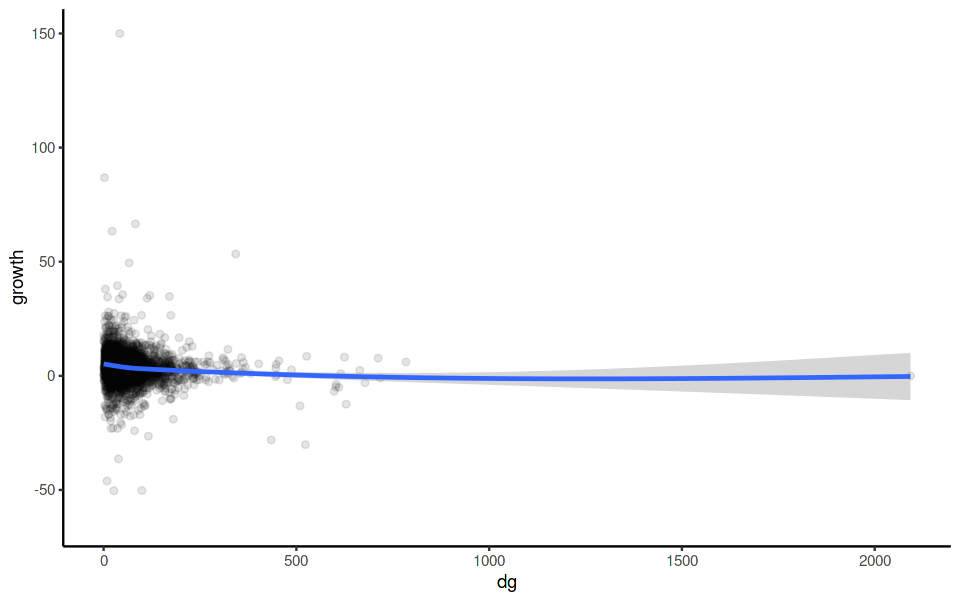

In [55]:
grdbt <- left_join(growth.wb1, hpdd)

ggplot(grdbt, aes(y=growth, x=dg)) + geom_point(alpha=0.1) + 
    geom_smooth()